# Anomaly Detection with Temperature, Humidity, and Gas Sensor Data

Based on https://github.com/BLarzalere/LSTM-Autoencoder-for-Anomaly-Detection

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# JSON file
json_file = "dataset/temp-humidity-gas-sensor-data-default-rtdb-export.json"

# Convert JSON to pandas dataframe
json_data = pd.read_json(json_file, orient='split')
dataset = json_data.transpose()
print(dataset)

dataset.to_csv("dataset/dataset.csv")

                       CO_PPM  humidity  temperature     timestamp
-MvcSM8n2zjpCYWQLTvU  3.84332      39.0         21.8  1.644578e+09
-MvcSOF8lv_CtymC_qTC  3.97888      38.0         21.8  1.644578e+09
-MvcSQgOdqNMFrPJT2OJ  3.97888      38.0         21.8  1.644578e+09
-MvcST7f63qislrlRoK9  3.95595      38.0         21.8  1.644578e+09
-MvcSV_-QmoXbj5VEpyY  4.00194      38.0         21.9  1.644578e+09
...                       ...       ...          ...           ...
-MvozH3ipUWFw-WonOw0  2.83316      47.0         21.7  1.644788e+09
-MvozJVu3BddkEnYpSIX  2.96710      47.0         21.7  1.644788e+09
-MvozLxDSTrQoGCKzxC4  2.97854      47.0         21.7  1.644788e+09
-MvozOcTjKdbmL-Yp5fM  2.98428      47.0         21.7  1.644788e+09
-MvozQq5gOK9uvNpjajW  2.99580      47.0         21.7  1.644788e+09

[1082 rows x 4 columns]


Text(0, 0.5, 'CO Concentration (PPM)')

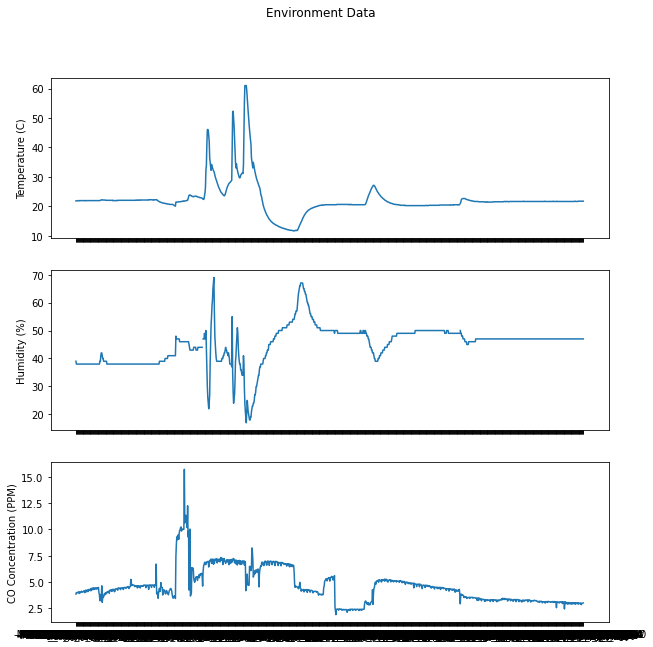

In [3]:
## Visualize the data

# Time-series visualization
fig, (temp_plot, hum_plot, gas_plot) = plt.subplots(3, sharex=True, figsize=(10,10))
fig.suptitle('Environment Data')

temp_data = dataset["temperature"]
humidity_data = dataset["humidity"]
co_data = dataset["CO_PPM"]

temp_plot.plot(temp_data)
temp_plot.set_ylabel("Temperature (C)")
hum_plot.plot(humidity_data)
hum_plot.set_ylabel("Humidity (%)")
gas_plot.plot(co_data)
gas_plot.set_ylabel("CO Concentration (PPM)")

Text(0.5, 0, 'CO Concentration (PPM)')

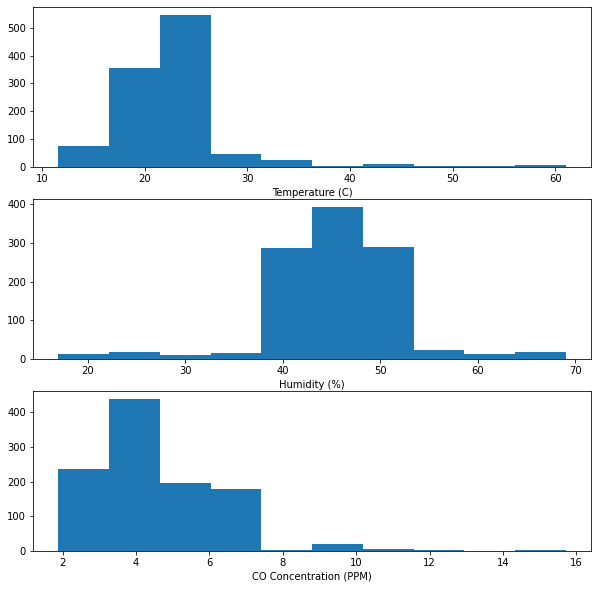

In [4]:
# Plot histogram
hist_fig, (temp_hist, hum_hist, gas_hist) = plt.subplots(3, figsize=(10,10))

temp_hist.hist(temp_data)
temp_hist.set_xlabel("Temperature (C)")

hum_hist.hist(humidity_data)
hum_hist.set_xlabel("Humidity (%)")

gas_hist.hist(co_data)
gas_hist.set_xlabel("CO Concentration (PPM)")

Text(0, 0.5, 'Humidity (%)')

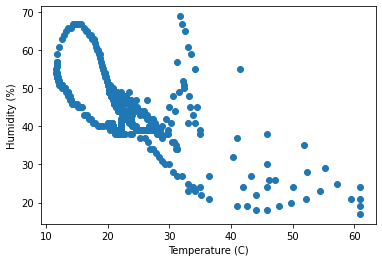

In [5]:
# Multivariate visualization
plt.scatter(temp_data, humidity_data)
plt.xlabel("Temperature (C)")
plt.ylabel("Humidity (%)")

Text(0.5, 0, 'CO Concentration (PPM)')

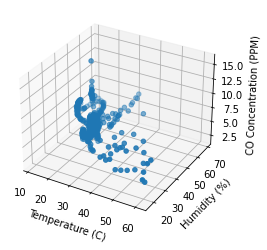

In [6]:
# Data for three-dimensional scattered points
multivar = plt.axes(projection='3d')
zdata = co_data
xdata = temp_data
ydata = humidity_data
multivar.scatter3D(xdata, ydata, zdata)

multivar.set_xlabel('Temperature (C)')
multivar.set_ylabel('Humidity (%)')
multivar.set_zlabel('CO Concentration (PPM)')

In [7]:
from sklearn.model_selection import train_test_split

# Drop timestamp column
dataset = dataset.drop(['timestamp'], axis =1)

# Drop incomplete rows
dataset = dataset.dropna(axis=0)

# Split the data
RANDOM_SEED = 101
x_train, x_test = train_test_split(dataset, test_size=0.2, random_state = RANDOM_SEED)

x_train = x_train.values
x_test  = x_test.values

print('Training data size   :', x_train.shape)
print('Validation data size :', x_test.shape)

dataset.head()

Training data size   : (864, 3)
Validation data size : (216, 3)


,CO_PPM,humidity,temperature
-MvcSM8n2zjpCYWQLTvU,3.84332,39.0,21.8
-MvcSOF8lv_CtymC_qTC,3.97888,38.0,21.8
-MvcSQgOdqNMFrPJT2OJ,3.97888,38.0,21.8
-MvcST7f63qislrlRoK9,3.95595,38.0,21.8
-MvcSV_-QmoXbj5VEpyY,4.00194,38.0,21.9


In [8]:
# Normalize the data to give equal importance to features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)

# print(x_train_scaled)
# print(x_test_scaled)

In [9]:
# reshape inputs for LSTM [samples, timesteps, features]
x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0], 1, x_train_scaled.shape[1])
print("Training data shape:", x_train_scaled.shape)
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], 1, x_test_scaled.shape[1])
print("Test data shape:", x_test_scaled.shape)

Training data shape: (864, 1, 3)
Test data shape: (216, 1, 3)


In [10]:
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [11]:
# create the autoencoder model
# optimizer = tf.optimizers.Adam(clipvalue=0.5)

model = autoencoder_model(x_train_scaled)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 3)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1280      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [12]:
# fit the model to the data
nb_epochs = 20
batch_size = 16
history = model.fit(x_train_scaled, x_train_scaled, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.1).history

Epoch 1/20
49/49 [==============================] - 6s 17ms/step - loss: 0.3076 - val_loss: 0.2749
Epoch 2/20
49/49 [==============================] - 0s 4ms/step - loss: 0.2376 - val_loss: 0.2057
Epoch 3/20
49/49 [==============================] - 0s 4ms/step - loss: 0.1636 - val_loss: 0.1394
Epoch 4/20
49/49 [==============================] - 0s 4ms/step - loss: 0.1038 - val_loss: 0.0972
Epoch 5/20
49/49 [==============================] - 0s 4ms/step - loss: 0.0844 - val_loss: 0.0882
Epoch 6/20
49/49 [==============================] - 0s 4ms/step - loss: 0.0804 - val_loss: 0.0857
Epoch 7/20
49/49 [==============================] - 0s 4ms/step - loss: 0.0790 - val_loss: 0.0847
Epoch 8/20
49/49 [==============================] - 0s 4ms/step - loss: 0.0778 - val_loss: 0.0834
Epoch 9/20
49/49 [==============================] - 0s 4ms/step - loss: 0.0764 - val_loss: 0.0815
Epoch 10/20
49/49 [==============================] - 0s 4ms/step - loss: 0.0747 - val_loss: 0.0795
Epoch 11/20
49/49 

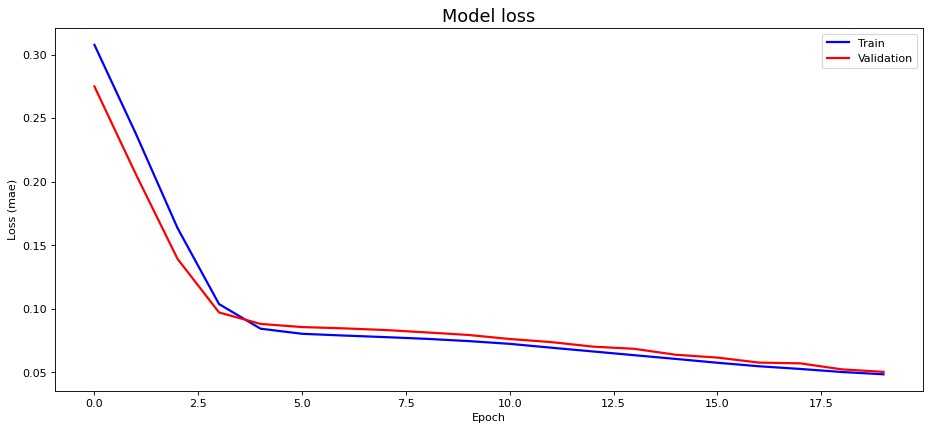

In [13]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

/Users/sheenafernandez/Library/Python/3.7/lib/python/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

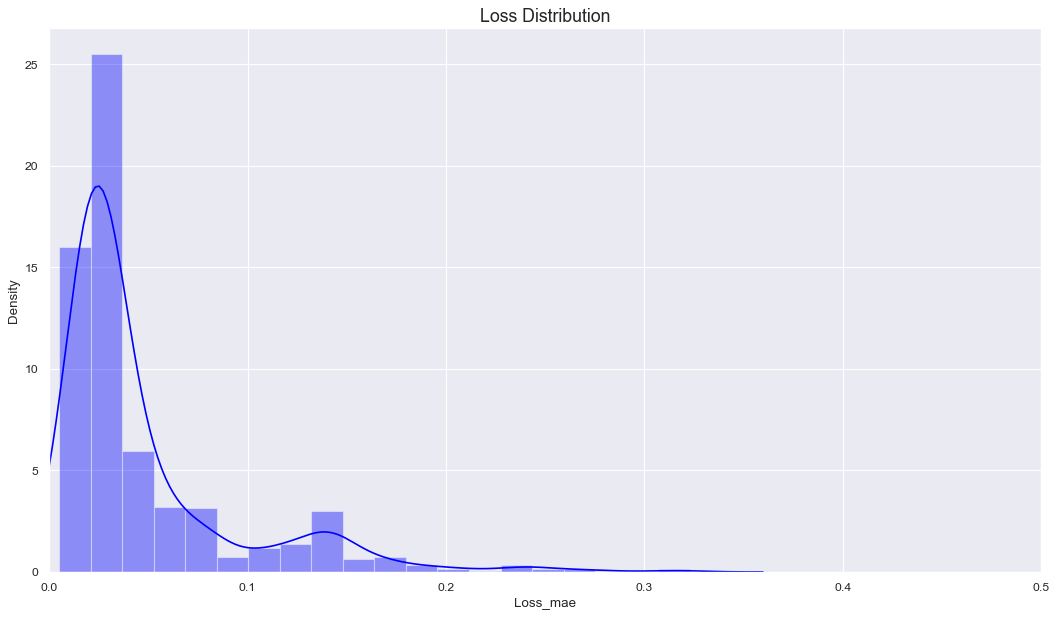

In [14]:
import seaborn as sns
sns.set(color_codes=True)

# plot the loss distribution of the training set
x_pred = model.predict(x_train_scaled)
x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[2])
x_train = pd.DataFrame(x_train)
x_pred = pd.DataFrame(x_pred, columns=x_train.columns)
x_pred.index = x_train.index

scored = pd.DataFrame(index=x_train.index)
xtrain = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[2])
scored['Loss_mae'] = np.mean(np.abs(x_pred-xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [15]:
# calculate the loss on the test set
x_pred = model.predict(x_test_scaled)
x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[2])
x_test = pd.DataFrame(x_test)
x_pred = pd.DataFrame(x_pred, columns=x_test.columns)
x_pred.index = x_test.index

scored = pd.DataFrame(index=x_test.index)
xtest = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[2])
scored['Loss_mae'] = np.mean(np.abs(x_pred-xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
0,0.022970,0.275,False
1,0.139762,0.275,False
2,0.073803,0.275,False
3,0.027716,0.275,False
4,0.041081,0.275,False


In [16]:
# Calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
x_pred_train = model.predict(x_train_scaled)
x_pred_train = x_pred_train.reshape(x_pred_train.shape[0], x_pred_train.shape[2])
x_pred_train = pd.DataFrame(x_pred_train, columns=x_train.columns)
x_pred_train.index = x_train.index

scored_train = pd.DataFrame(index=x_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(x_pred_train-xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:>

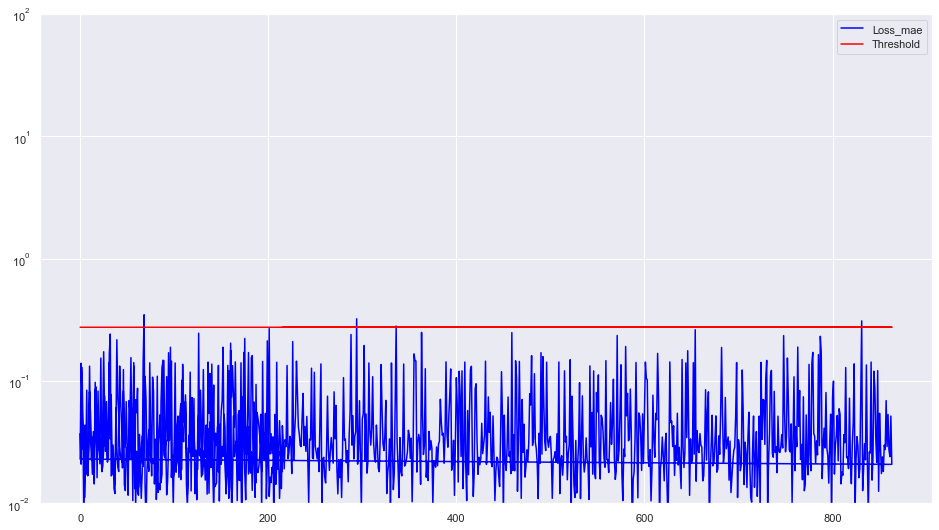

In [17]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

In [18]:
# Save the trained model
model.save("model.h5")